#### Load required libraries

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pyviscous import pyviscous as vs

#### Configurations

In [19]:
# Specify the path of the given input-output data file.
sampleFile = os.path.join('input_output_data.txt') 

# Define a folder to save sensitivity results.
outputDir  = './output' 
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

#### 1. Load input-output data

In [24]:
# Load data.
data = np.loadtxt(sampleFile, skiprows=1, delimiter='\t')
x    = data[:,1:-1]
y    = data[:,-1].reshape(-1,1)    

# Get the number of data samples (n_samples), and the number of x variables (n_xvariables).
(n_samples, n_xvariables) = np.shape(x)
print('n_samples=%d, n_xvariables=%d'%(n_samples,n_xvariables))

n_samples=16489, n_xvariables=12


In [4]:
# Load parameter names.
first_row = np.genfromtxt(sampleFile, dtype=str, max_rows=1)
# Convert the numpy array to a list.
variable_names = first_row.tolist()

# Exclude the first and last columns.
variable_names = variable_names[1:-1]
# Exclude "multp" from the variable name.
variable_names =  [var.replace('_multp', '') for var in variable_names]

#### 2. Visualize input-output data [Optional] 
Scatter plot between multipliers(X) and -KGE(Y). Useful for screening and ranking. <br>
Uniformly scattered points like in the 1st panel indicate low sensitivity (to k_macropore here). <br>
Patterns like in the 8th panel denote high sensitivity (to frozenPrecipMultip here). 

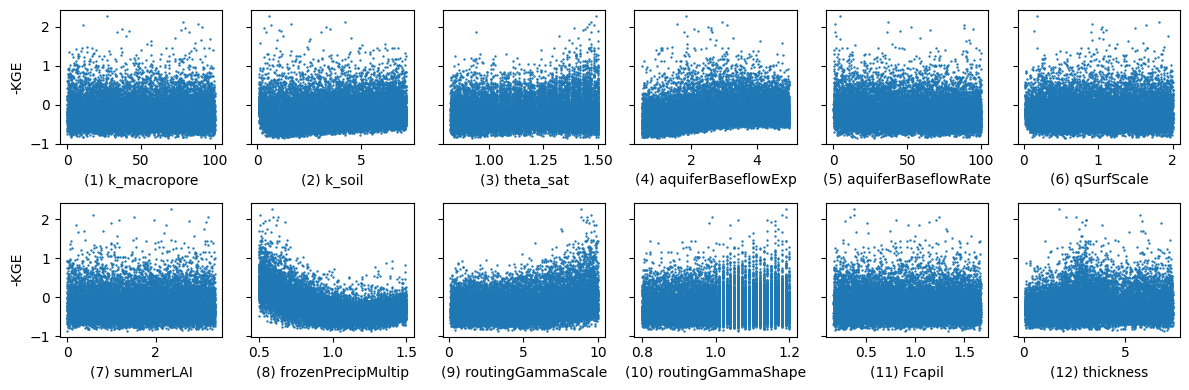

In [15]:
fig, axs = plt.subplots(2, 6, figsize=(12, 4), sharey=True)
for i in range(2): 
    for j in range(6):
        iVar = i*6+j
        axs[i, j].scatter(data[:, 1+iVar], data[:, -1], s=0.5)        
        axs[i, j].set_xlabel('(%d) %s'%(iVar+1, variable_names[iVar]))
        if j==0:
            axs[i, j].set_ylabel('-KGE')
plt.tight_layout()
plt.show()

#### 3. Calculate the first-order sensitivity index
The first-order sensitivity index indicates the sensitivity of the model output (e.g., -KGE) to a model parameter while keeping all other parameters fixed. It represents the direct influence of each individual model parameter on the model output. <br>

---
Input Argument Explanations for the **vs.viscous** Function:  
- **x**: array, shape **(n_samples, n_xvariables)**. Input values in the input space. 
- **y**: array, shape **(n_samples, 1)**. Output values in the output space. 
- **xIndex**: **int**. The index of the evaluated input variable, starting from zero. 
- **sensType**: **str**. Type of sensitivity index calculation. Options: 'first', 'total'. <br>
*Optional:*
- **N1**: **int**, optional, default: 2000. Number of Monte Carlo samples used for the outer loop.
- **N2**: **int**, optional, default: 2000. Number of Monte Carlo samples used for the inner loop.
- **n_components**: **{int, 'optimal'}**, optional, default: **'optimal'**. The number of components used in GMCM inference. If **'optimal'**, it looks for an optimal number of components in the range of **[1, 9]**.
- **MSC**: **str**, optional, default: **'AIC'**. Model selection criteria. Options: 'AIC', 'BIC'.
- **verbose**: **bool**, optional, default: **False**. Display detailed processing information on your screen.

For more detailed information about the function, please refer to the source code of **pyviscous**.

---
#### Note for users:
The following **for** loop is currently set up to only process the 7th parameter (xIndex 7, counting from 0), corresponding to the input variable named "frozenPrecipMultip". This is done to demonstrate usage and save computation time.

When working with many parameters, consider parallelizing this loop to speed up computation, especially when using high-performance computing resources.


In [23]:
# Load input-output data.
data = np.loadtxt(sampleFile, skiprows=1, delimiter='\t')
x    = data[:,1:-1]
y    = data[:,-1].reshape(-1,1)    

# Loop xIndex to calculate each input variable's first-order sensitivity indices.
ofile = os.path.join(outputDir,'sens_first.txt')
f = open(ofile, 'w') 
f.write("ID\tValue\n")
    
for xIndex in [7]:
# Use the following line instead to compute sensitivity indices for all parameters:
# for xIndex in range(n_xvariables): 
    
    # Calculate sensitivity index.
    sens_indx_first, gmcm_first = vs.viscous(x, y, xIndex, 'first', MSC='AIC')  
    
    # Write each result.
    f.write(f"{xIndex + 1}\t{sens_indx_first}\n")  
    
f.close()

Calculating first-order sensitivity index for variable index 7...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  6
    Sensitivity index = 0.458424


#### 4. Calculate the total-order sensitivity index
The total-order sensitivity index indicates the sensitivity of the model output (e.g., -KGE) to a model parameter, accounting for both direct and interation effects with other parameters. It reflects the overall importance of a model parameter, considering its direct impact as well as its influence through interactions with other parameters. <br>

Input argument explanations for the **vs.viscous** function are consistent with those provided above.

In [22]:
# Load input-output data.
data = np.loadtxt(sampleFile, skiprows=1, delimiter='\t')
x    = data[:,1:-1]
y    = data[:,-1].reshape(-1,1)    

# Loop xIndex to calculate each input variable's total-order sensitivity indices.
ofile = os.path.join(outputDir,'sens_total.txt')
f = open(ofile, 'w') 
f.write("ID\tValue\n")
    
for xIndex in [7]:
# Use the following line instead to compute sensitivity indices for all parameters:
# for xIndex in range(n_xvariables):     
   
    # Calculate sensitivity index.
    sens_indx_total, gmcm_first = vs.viscous(x, y, xIndex, 'total', MSC='AIC')     
    
    # Write each result. 
    f.write(f"{xIndex + 1}\t{sens_indx_total}\n")   
    
f.close()

Calculating total-order sensitivity index for variable index 7...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  9
    Sensitivity index = 0.694642


#### 5. Visualize the first- and total-order sensitivity indices
The obtained sensitivity results align well with those reported by [Gharari et al. (2020)](https://doi.org/10.5194/hess-24-5953-2020) and [Sheikholeslami et al. (2021)](https://doi.org/10.1029/2020WR028435), proving the consistency and reliability of our findings.

In [5]:
# Load sensitivity results.
# Specify sensitivity result files.
first_order_file = os.path.join(outputDir,'sens_first.txt')
total_order_file = os.path.join(outputDir,'sens_total.txt')

# Load sensitivity results.
first_order_indices = np.loadtxt(first_order_file, skiprows=1, usecols=[1], delimiter='\t')
total_order_indices = np.loadtxt(total_order_file, skiprows=1, usecols=[1], delimiter='\t')

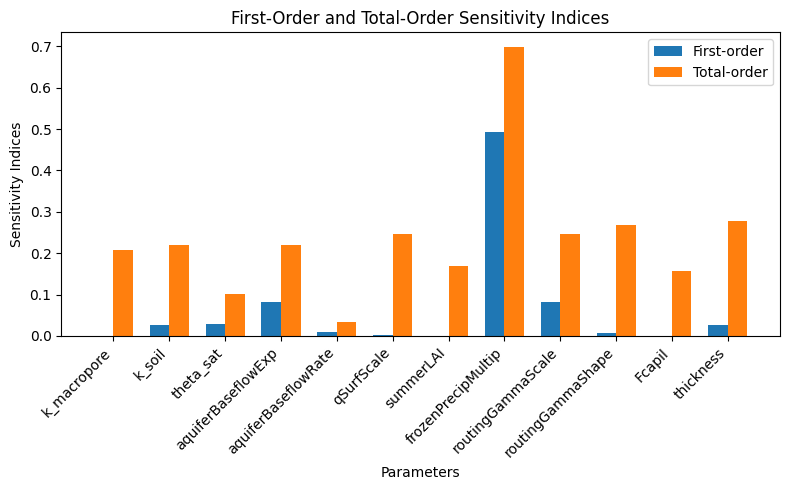

In [11]:
# Plot sensitivity results.
bar_width = 0.35
index = range(len(variable_names))

fig, ax = plt.subplots(figsize=(8, 5))
bar1 = ax.bar(index, first_order_indices, bar_width, label='First-order')
bar2 = ax.bar([i + bar_width for i in index], total_order_indices, bar_width, label='Total-order')

# Add labels, title, and legend.
ax.set_xlabel('Parameters')
ax.set_ylabel('Sensitivity Indices')
ax.set_title('First-Order and Total-Order Sensitivity Indices')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(variable_names, rotation=45, ha='right')
ax.legend()

# Display and  save the plot.
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(outputDir,'sens_plot.png'))